Introduction to Markov modelling with pyEMMA - Estimate MSM
=====

<pre> 
Antonia Mey                antonia.mey@fu-berlin.de  
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
Frank Noe                  frank.noe@fu-berlin.de    

Modified for starting from discrete trajectories.
</pre>

Basic imports:

In [1]:
import os
import numpy as np
import pyemma.coordinates as coor
import shortcuts
%pylab inline

Populating the interactive namespace from numpy and matplotlib


MSM estimation
---------
In this chapter we want to estimate a Markov model, and then analyze it. First we import the msm package from pyemma, and then we also import a plotting package which offers a few standard ways for visualizing data.

In [2]:
import pyemma.msm as msm
import pyemma.plots as mpl

Coordinate transform (not carried out here)
------

This first block shows how we would obtain the discrete trajectories. Since the full trajectories are not provided this part is commented out and we start below with the discrete trajectories.

In [3]:
#trajfile = 'data/bpti_ca_1ms_dt10ns.xtc'
#topfile = 'data/bpti_ca.pdb'
# featurizer
#feat = coor.featurizer(topfile)
#feat.add_all()
# input
#inp = coor.source(trajfile, feat)
# tica + projection
#tica_obj = coor.tica(inp, lag=100, dim=2)
#Y = tica_obj.get_output()[0]
# clustering
#cl = coor.cluster_kmeans(data=Y, k=100, stride=10)
# for later use we save the discrete trajectories and cluster center coordinates:
#dtrajs = cl.dtrajs

Load discrete trajectories, clustercenters and histogram
------
Here we directly start by loading the discrete trajectories, clustercenters and the data histogram:

In [4]:
#load discrete trajectories
indir = 'data/'
infiles = [os.path.join(indir, filename) for filename in os.listdir(indir)];
dtrajs = []
for filename in infiles:
    if filename.endswith('.dtraj'):
        dtraj = msm.io.read_dtraj(filename)
        dtrajs.append(dtraj)
#load clustercenters
clustercenters = np.loadtxt(indir+'BPTI-clustercenters.dat')
cc_x = clustercenters[:,0]
cc_y = clustercenters[:,1]
# load histogram
histogram_xy = np.loadtxt(indir+'BPTI-histogram_xy.dat')
z = np.loadtxt(indir+'BPTI-histogram_z.dat')
x = histogram_xy[0]
y = histogram_xy[1]
F = -np.log(z)
extent = [x[0], x[-1], y[0], y[-1]]

/storage/mi/nplattner/miniconda/envs/PyE-test/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Check if everything has been loaded correctly:

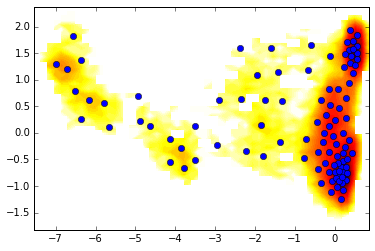

In [5]:
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

# Estimate Markov state model

The quality and the practical usefulness of a Markov model depend on two main parameters:

1. The state-space discretization, i.e. which steps we have conducted before (choice of coordinates, projection method, clustering method)
2. The lag time, i.e. at which time do we count transitions.

The first choice is quite complex and there are some ways to deal with this complexity and the reduce the number of choices, although we won't discuss them in detail here. The second parameter is extremely important, and we should scan it in order to make a good selection. So Let us compute the so-called implied timescales, or relaxation timescales of the Markov model at different lag times:

In [6]:
lags = [1,2,5,10,20,50,100,200]
its = msm.its(dtrajs, lags=lags)

What this function does is to estimate a Markov model at each of the given lag times $\tau$ (that are multiples of our saving step, i.e. multiples of 10 ns), compute the eigenvalues of each transition matrix, $\lambda_i(\tau)$, and then compute the relaxation timescales by:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}$$
The its object will mainly give us these estimated timescales. We can simply push the result to a standard plotting function:

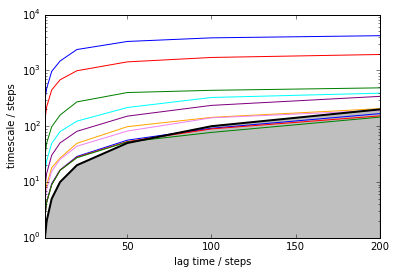

In [7]:
mpl.plot_implied_timescales(its)

It has been shown [3] that these timescales should be independent of the lag time. You can see that for short lag times they are not, but after about 100 steps (1 microsecond), they are pretty constant. The faster timescales still increase. Part of this is normal and due to numerical issues. Part of this is because our state space discretization is rather naive - we cannot hope to capture a lot of relaxation processes when using only two dimensions.

In a nutshell: longer timescale is better, at least as long you stay away from the grey area. The grey area is defined by lag > timescale, and in this area we cannot make a reliable estimate because the process under investigation has already decayed. Everything within or close to the grey area is distorted.

Of course looking at a plot and judging the flatness by eye is not really sophisticated. Especially because the error bars on these timescales can be pretty big. Let's compute some errors using bootstrapping and plot again...

In [8]:
its.bootstrap(nsample=10)

(0, 200)

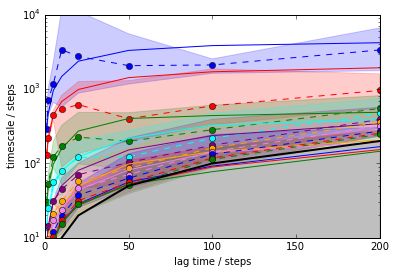

In [9]:
mpl.plot_implied_timescales(its)
ylim(10,10000)
xlim(0,200)

So you see that to be constant within the error bars, we could even use shorter lag times. But let's go with 100 for now.

MSM
---
So finally we can estimate a Markov model. In fact we have already estimated a several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering and the lag time:

In [10]:
M = msm.estimate_markov_model(dtrajs, 100)

The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [11]:
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 10.5)

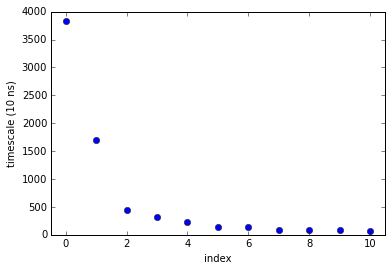

In [12]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5)

We can also look at that data by taking the ratios of subsequent timescales. This shows us how big the gap of timescales (or rates) are.

(-0.5, 10.5)

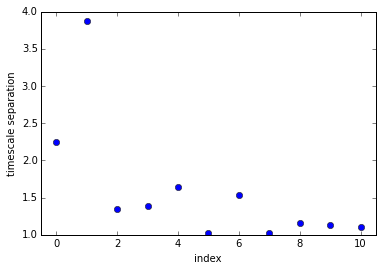

In [13]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

It can be seen that there is a large timescale separation between the second and third relaxation timescale. That means that if we are interested in coarse-graining our dynamics, retaining two relaxation timescales, or three metastable states, is a good choice.

Now let us look at the second (slowest) right eigenvector

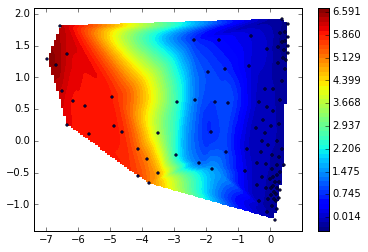

In [14]:
r2 = M.eigenvectors_right()[:,1]
ax = mpl.scatter_contour(cc_x, cc_y, r2)

Clearly, the slowest process (about 40 microseconds) involves a change along the first TICA component. This is great news for TICA, because it means that even before computing a Markov model we have done a very good job in finding a slow order parameter. However, remember that this process has occurred only once in the trajectory, so unfortunatly our data is quite poor with respect to quantifying it.

Let us then look at the third (next-slowest) right eigenvector

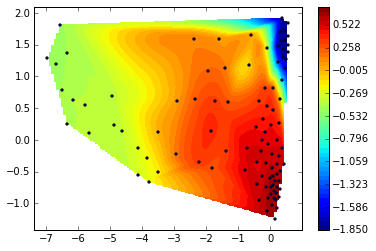

In [15]:
r3 = M.eigenvectors_right()[:,2]
mpl.scatter_contour(cc_x, cc_y, r3)

This process is between 15 and 20 microseconds and clearly transitions between the two prominent minima in the region of x=0.

Now we want to coarse-grain our system to get a simpler description. The PCCA method [4] uses the eigenvectors in order to perform a spectral clustering. This clustering is fuzzy, i.e. each of our k-means clusters is linked to one of the metastable states with a certain probability or membership. Here we plot the Bayesian inverse, i.e. the probability to be in a small state given that we are in a metastable state. We choose three metastable states, so we have three distributions:

In [16]:
M.pcca(3)
pcca_dist = M.metastable_distributions

In [17]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)

and now we could save them, but we don't have the initial trajecories...

In [18]:
#coor.save_traj(inp, pcca_samples[0], './data/pcca1_100samples.xtc')
#coor.save_traj(inp, pcca_samples[1], './data/pcca2_100samples.xtc')
#coor.save_traj(inp, pcca_samples[2], './data/pcca3_100samples.xtc')

At this point, have a look at the structures with VMD or your favorite viewer. Here we have pre-generated a figure with a "front", "side" and "top" view of the structures. 

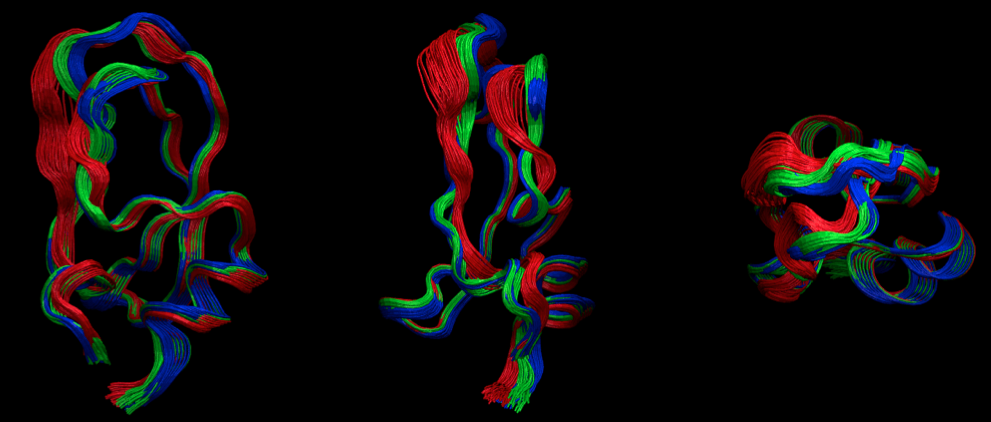

In [19]:
from IPython.display import Image
Image(filename='./data/pcca_structures.png', width=800) 

So you see that the red state is more flexible has a loop folded outward while the other two states are more compact and quite similar. Probably there are more differences in the side-chains, but we don't have the all-atom data here to go further at this point. You get the idea how to do this though...

In order to relate the structures above to the metastable states on our TICA plot, let us (ab)use PCCA to do a crisp clustering, and show the colors correspondingly. We can see that the red state is our single event state on the right hand side:

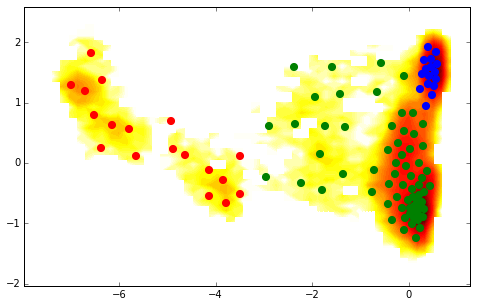

In [20]:
figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
scatter(clustercenters[pcca_sets[0],0], clustercenters[pcca_sets[0],1], color='red', s=50)
scatter(clustercenters[pcca_sets[1],0], clustercenters[pcca_sets[1],1], color='blue', s=50)
scatter(clustercenters[pcca_sets[2],0], clustercenters[pcca_sets[2],1], color='green', s=50)

Let's play
------

Go to the documentation of the MSM object. 

    http://www.pythonhosted.org/pyEMMA/api/generated/pyemma.msm.ui.EstimatedMSM.html

You can see that there are a lot of functionalities. Don't try to read everything, but let's go at specific functionalities one by one.

1. Try to do that and plot the metastable distributions *pcca_dist* in the same way like the eigenvectors above.
2. Having done pcca allows to compute other properties of the metastable decomposition. Try them out and read in the documentation what they do. Try to understand what they mean.
3. MSM trajectory: Although there is no mathematical argument in favor of doing this, this might be fun. Use the MSM to generate a synthetic trajectory of 100 milliseconds with *generate_traj*. Remember we estimated the MSM at a lag time of 1 microsecond, that tells you how many steps you need to make. Inspect the result and try to understand why it is formatted like that. Since you have the cluster centers in *cl*, you can assign the trajectory to them and plot the TICA coordinate trajectory for 100 milliseconds. You can also save the trajectory using *coor.save_traj* and then look at it with VMD.
3. Experimental observables: Load the representative structures (above) in VMD or another viewer and try to find out which Ca-Ca distance would be a good choice to detect the slow conformational change (between red and green/blue metastable sets). Here's a hint how to compute the value of your chosen distance along the original trajectory and the means of that value on each cluster center:
```python
    # here you have to insert the ca-indexes you have choosen (VMD starts counting from 1, we  from 0)
    ca1 = 0
    ca2 = 1
    # load this distance feature
    feat2 = coor.featurizer(topfile)
    feat2.add_distances(np.array([[ca1, ca2]]))
    D = coor.load(trajfile, feat2)
    # average over msm states
    dmean = shortcuts.average_by_state(dtrajs[0], D, M.nstates)
```
4. Plot the time trace of your selected distance. How large are the changes of that distance compared to noise? Compare the time trace to the first TICA coordinate. Have you made a good choice?
5. Plot the mean values of the observable on the TICA coordinates like you did for the eigenvectors above.
6. Review the msm functions *expectation*, *correlation*, and *relaxation*. Use these functions to design an experiment that measures the 40 microsecond relaxation timescale. Plot the results of these functions and try to find out if they exhibit the 40 microsecond decay. Note: a useful way to follow exponential decays over time is to do a semi-log plot using *semilogy()* after a plot

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
3. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
4. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
5. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
6. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)